# Huffman Codes

## Generating an Optimal Prefix-Free Code

### What does 'optimal' even mean?

Imagine we're working with the text:

In [149]:
text = "aabbabcabcd"

Optimal codes must assign *shorter* codes to *more frequent* symbols.  Let's get a frequency table of the symbols:

In [150]:
freqs = dict([(x, len([y for y in text if y == x])) for x in set(text)]); freqs

{'b': 4, 'c': 2, 'a': 4, 'd': 1}

We claim the following:

**Property 1:** In an optimal code, the two longest codes must be of the same length.

In this case, 'c' and 'd' should be the two longest codes. So, they must have the same length (and thus, they must be the same distance to the root of the code tree):

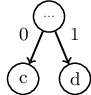

In [1]:
%%tree --binary 
x/"\tiny{...}" ->["0",swap] c, x ->["1"] d/"d" 

In total, there are 3 characters that are 'c' or 'd'.  We mentally "collapse" the prefix of c and d into a single character which we'll call "cd".  Then, we can recursively apply **Property 1** to the codebook:

In [152]:
{'b': 4, 'cd': 3, 'a': 4}

{'b': 4, 'cd': 3, 'a': 4}

'cd' should clearly be one of the longest codes, but we have a choice to make either 'a' or 'b' the other one.  Let's choose 'a'.  So, then, we have:

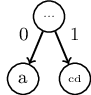

In [2]:
%%tree --binary 
x/"\tiny{...}" ->["0",swap] a, x ->["1"] cd/"\tiny{cd}"

Applying the same idea, we now have 'acd' and 'b' left which gives us:

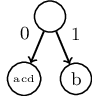

In [4]:
%%tree --binary 
a/"" ->["0",swap] acd/"\tiny{acd}", a/"" ->["1"] b

Since this was recursive, we can put all the trees together recursively to get 

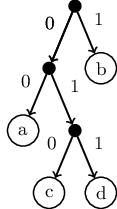

In [3]:
%%tree --binary 
x/""[fill,minimum height=0.5em] ->["0",swap] x0/""[fill,minimum height=0.5em] ->["0",swap] a,
x/"" ->["1"] b,
x/"" ->["0",swap] x0/"" ->["1"] x01/""[fill,minimum height=0.5em] ->["0",swap] c,
x01 ->["1"] d

We've now constructed a complete code for the original alphabet by applying **Property 1** recursively. This, of course, leads to the following algorithm:

In [156]:
freq_list = [(v, k) for (k,v) in freqs.items()]; freq_list

[(4, 'b'), (2, 'c'), (4, 'a'), (1, 'd')]

In [157]:
def construct_prefix_free_code_tree(freq_list):
    """freqs is a list of frequency pairs (a, b), where a is the frequency of b in the input corpus"""
    if len(freq_list) == 1:
        # Return the constructed tree from the only remaining element
        return freq_list[0][1]
    # Make sure the frequency list is sorted and take the two least used symbols
    freq_list = sorted(freq_list)
    a = freq_list.pop(0)
    b = freq_list.pop(0)
    
    # Recursively construct the prefix-free code by treating the combination of a & b as a single symbol
    return construct_prefix_free_code_tree(freq_list + [(a[0] + b[0], (a[1], b[1]))])

In [158]:
tree = construct_prefix_free_code_tree(freq_list); tree

('b', (('d', 'c'), 'a'))

To get the actual codebook from the tree, we need to traverse all paths of the tree as follows:

In [159]:
def make_codebook_from_code_tree(code_tree, acc=""):
    # We found a particular code; this means we're at a leaf
    if isinstance(code_tree, str):
        return [(code_tree, acc)]
    
    # Recurse by trying going left and trying going right; concatenate the two results
    return make_codebook_from_code_tree(code_tree[0], acc + "0") +\
           make_codebook_from_code_tree(code_tree[1], acc + "1") 

In [160]:
codebook = make_codebook_from_code_tree(tree); codebook

[('b', '0'), ('d', '100'), ('c', '101'), ('a', '11')]

Sanity checking that the resulting code is actually prefix free gives us:

In [161]:
def is_prefix_free(codebook):
    # Compare all 
    for i in range(len(codebook)):
        for j in range(len(codebook)):
            # If one of any pair is a prefix of the other, it's not a prefix-free code
            if i != j and codebook[i].startswith(codebook[j]):
                return False
    return True
is_prefix_free([x[1] for x in codebook])

True

## Compressing Using a Codetable

To compress text using this algorithm, we can just use the codebook directly:

In [162]:
codebook = dict(codebook)

In [163]:
def compress(codebook, text):
    result = []
    # Repeatedly convert a single symbol to multiple bits
    for x in text:
        result.append(codebook[x])
    return "".join(result)

In [164]:
data = compress(codebook, text); data

'111100110101110101100'

Decompression is slightly more interesting.  We have two options: (1) use the "reverse" table and (2) use the tree directly.

## Decompressing Using a Table

In [165]:
reverse_codebook = {v:k for (k,v) in codebook.items()}; reverse_codebook

{'0': 'b', '100': 'd', '101': 'c', '11': 'a'}

In [166]:
def decompress_with_codebook(reverse_codebook, data):
    result = []
    buf = ""
    for x in data:
        buf += x
        # Check if the current buffer constitutes an entire symbol
        if buf in reverse_codebook:
            # If it does, reset the buffer and output that symbol
            result.append(reverse_codebook[buf])
            buf = ""
    return "".join(result)

In [167]:
decompress_with_codebook(reverse_codebook, data)

'aabbabcabcd'

In [168]:
_ == text

True

## Decompressing Using a Tree

In [169]:
def decompress_with_tree(tree, data):
    result = []
    data = list(data)
    # While there are more bits...
    while len(data) > 0:
        t = tree
        # Check if we hit a leaf of the tree
        while not isinstance(t, str):
            # If we didn't, traverse the tree in the direction of the bit we got
            t = t[int(data.pop(0))]
        result.append(t)
    return "".join(result)

In [170]:
decompress_with_tree(tree, data)

'aabbabcabcd'

In [171]:
_ == text

True